In [1]:
%load_ext autoreload
%autoreload 2
!hostname
!pwd
import os, sys
print(sys.executable)
os.environ['CUDA_VISIBLE_DEVICES'] = "7"

fish-gcp005
/home/akarshkumar0101/nca-alife/src
/home/akarshkumar0101/miniconda3/envs/nca-alife-jax/bin/python


In [2]:
import os, sys, glob, pickle
from functools import partial

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from tqdm.auto import tqdm
from einops import rearrange, reduce, repeat

In [3]:
import experiment_utils
import util

# Create Experiment

In [4]:
! rm -rf ./experiments
! mkdir -p ./experiments

In [5]:
# img_tgt
# nca_tgt
# img_clip
# nca_clip

In [6]:
prompts = [
    # "a red apple;a green apple;a blue apple;a red apple",
    # "a skinny cat;a normal cat;a fat cat;a very very fat cat",
    # "a red apple;a green tree;a cute dog;the yellow sun",
    # "random noise;self-replicating molecules;cells floating in primordial soup;alien animals roaming around",
    
    # "a bustling luscious nature landscape",
    # "an artificial life simulation",
    # "self-replication emerging in an artificial life simulation",
    # "a photo of the emergence of open-ended complexity",
    
]

In [7]:
prompt = ';'.join([
        "many molecules and chemicals randomly floating around",
        "chemicals coming together to form a cell",
        "a single cell moving around",
        "a cell reproducing to create more cells",
        "many cells moving around",
        "a bustling diverse ecosystem of cells floating around",
        "many cells coming together to form a bigger cell",
        "bigger cells chasing smaller cells in predator-prey like dynamics",
    ])

In [18]:
cfg_default = dict(
    seed=0, save_dir=None, dtype='float32', device='cuda:0',
    
    img_size=64, n_layers=2, d_state=16, d_embd=32, locality=1, kernel_size=3, nonlin="GELU",
    
    init_state="point", padding_mode="zeros", dt=0.01, p_drop=0.0,
    
    rollout_steps=64, bptt_steps=16, pool_size=1024,
    
    target_img_path=None, prompt="a green tree", n_augs=1, augs="crop+pers", clip_model="clip-vit-base-patch32",
    
    coef_alignment=0., coef_softmax=0., coef_temporal=0.,
    
    bs=8, lr=1e-3, n_iters=10000, clip_grad_norm=1.
)

cfgs = []

seeds = np.arange(1)
coef_softmaxes = np.logspace(-5, 1, 48)

for seed in seeds:
    for i1, cs in enumerate(coef_softmaxes):
        cfg = cfg_default.copy()
        cfg.update(prompt=prompt, rollout_steps=512, lr=3e-4, n_iters=160000)

        cfg.update(seed=seed, coef_alignment=1., coef_softmax=cs, coef_temporal=0.)
        cfg.update(save_dir=f"/home/akarshkumar0101/nca-alife-data/nca_multi_prompt_clip/cell_prompt_new_cs_{seed=}_{i1=}")
        cfgs.append(cfg)


In [19]:
commands = experiment_utils.create_commands(cfgs, prefix='python nca_multi_prompt_clip.py', out_file='./experiments/main.sh')
print('\n'.join(commands[:3]), '\n...')
print(len(commands), 'commands')

python nca_multi_prompt_clip.py --seed=0 --save_dir="/home/akarshkumar0101/nca-alife-data/nca_multi_prompt_clip/cell_prompt_new_cs_seed=0_i1=0"  --dtype="float32" --device="cuda:0" --img_size=64 --n_layers=2 --d_state=16 --d_embd=32 --locality=1 --kernel_size=3 --nonlin="GELU" --init_state="point" --padding_mode="zeros" --dt=0.01 --p_drop=0.0 --rollout_steps=512 --bptt_steps=16 --pool_size=1024 --target_img_path=None --prompt="many molecules and chemicals randomly floating around;chemicals coming together to form a cell;a single cell moving around;a cell reproducing to create more cells;many cells moving around;a bustling diverse ecosystem of cells floating around;many cells coming together to form a bigger cell;bigger cells chasing smaller cells in predator-prey like dynamics" --n_augs=1 --augs="crop+pers" --clip_model="clip-vit-base-patch32" --coef_alignment=1.0 --coef_softmax=9.999999999999999e-06  --coef_temporal=0.0 --bs=8 --lr=0.0003 --n_iters=160000 --clip_grad_norm=1.0
python n

# Visualize Results

  0%|          | 0/48 [00:00<?, ?it/s]

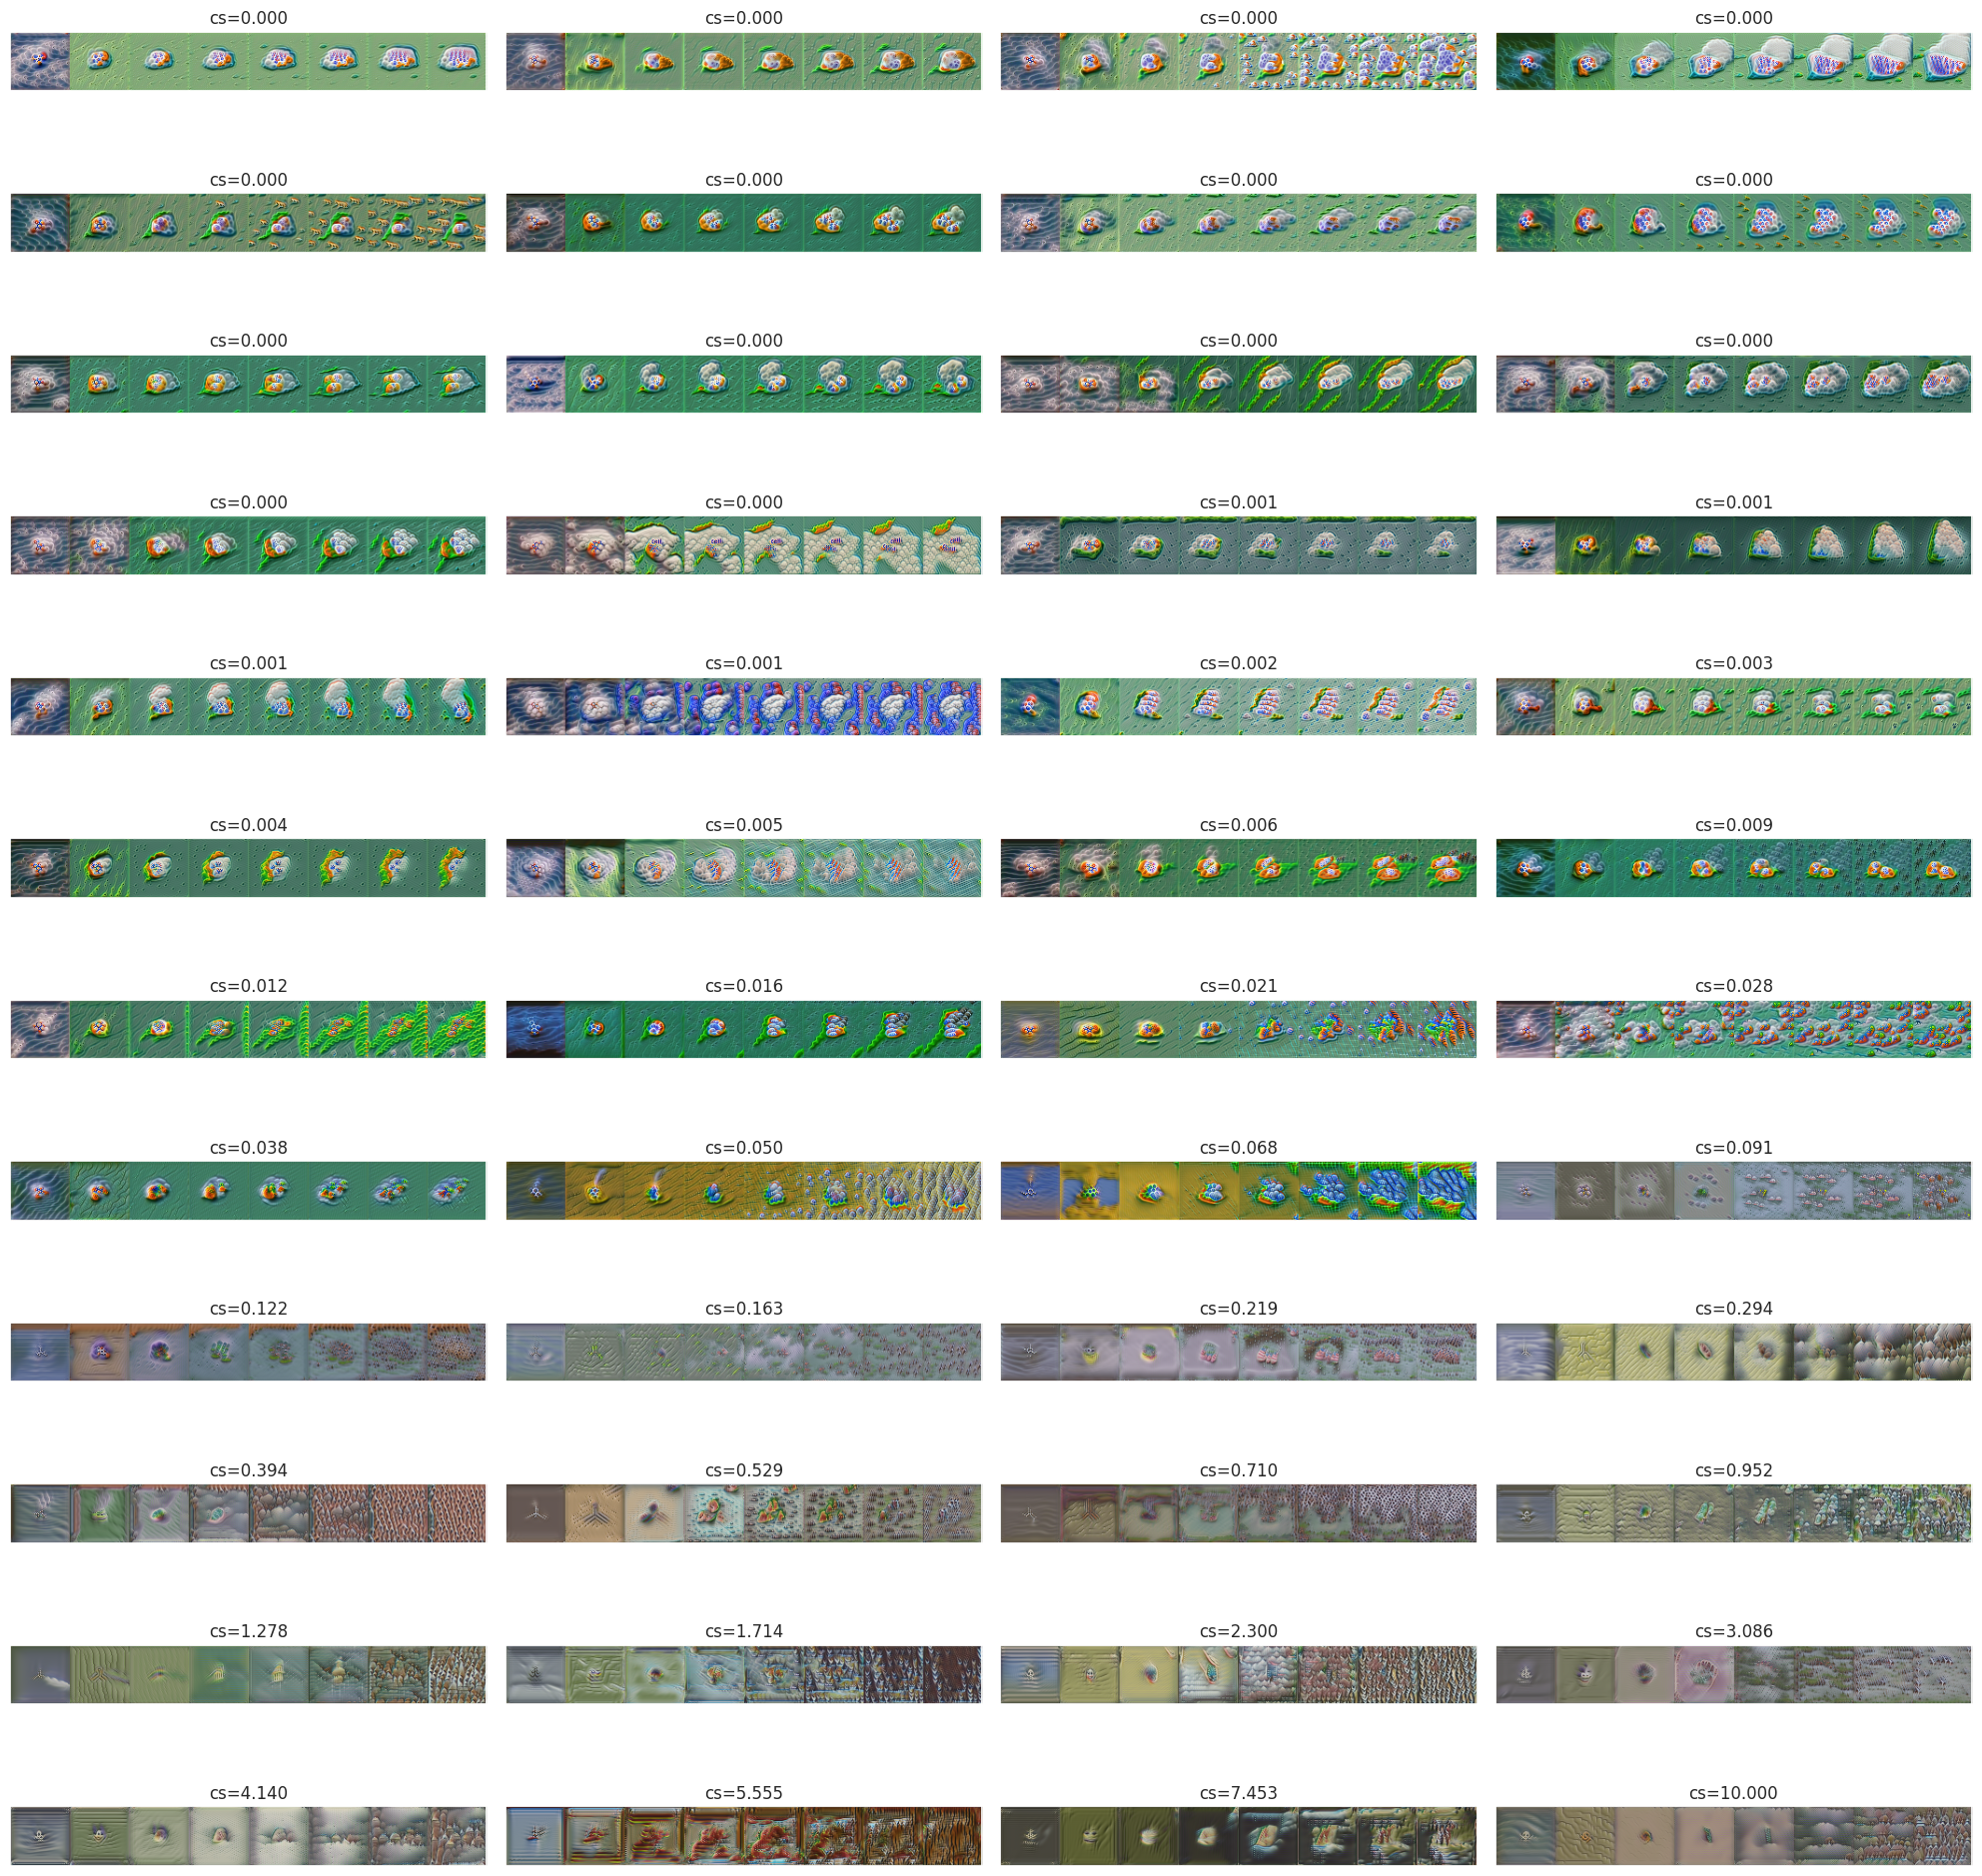

In [64]:
plt.figure(figsize=(20, 20))
iplt = 0

seed = 0
for i1, cs in enumerate(tqdm(coef_softmaxes)):
    save_dir=f"/home/akarshkumar0101/nca-alife-data/nca_multi_prompt_clip/cell_prompt_new_cs_{seed=}_{i1=}"
    vid = util.load_pkl(save_dir, "vid").astype(np.float32)

    iplt += 1
    plt.subplot(12, 4, iplt)
    plt.imshow(rearrange(vid[:1, 32::64], 'B T H W D -> (B H) (T W) D'))
    plt.title(f'{cs=:.3f}')
    plt.grid(False)
    plt.xticks([]); plt.yticks([])
plt.tight_layout()
plt.show()

    

In [50]:
df = []
seed = 0
for i1, cs in enumerate(tqdm(coef_softmaxes)):
    save_dir=f"/home/akarshkumar0101/nca-alife-data/nca_multi_prompt_clip/cell_prompt_new_cs_{seed=}_{i1=}"
    losses = util.load_pkl(save_dir, "losses")
    dfi = {k: v[-40000:].mean() for k, v in losses.items()}
    dfi.update(coef_alignment=1., coef_softmax=cs)
    df.append(dfi)
df = pd.DataFrame(df)

df['log_coef_softmax'] = np.log(df.coef_softmax)

  0%|          | 0/48 [00:00<?, ?it/s]

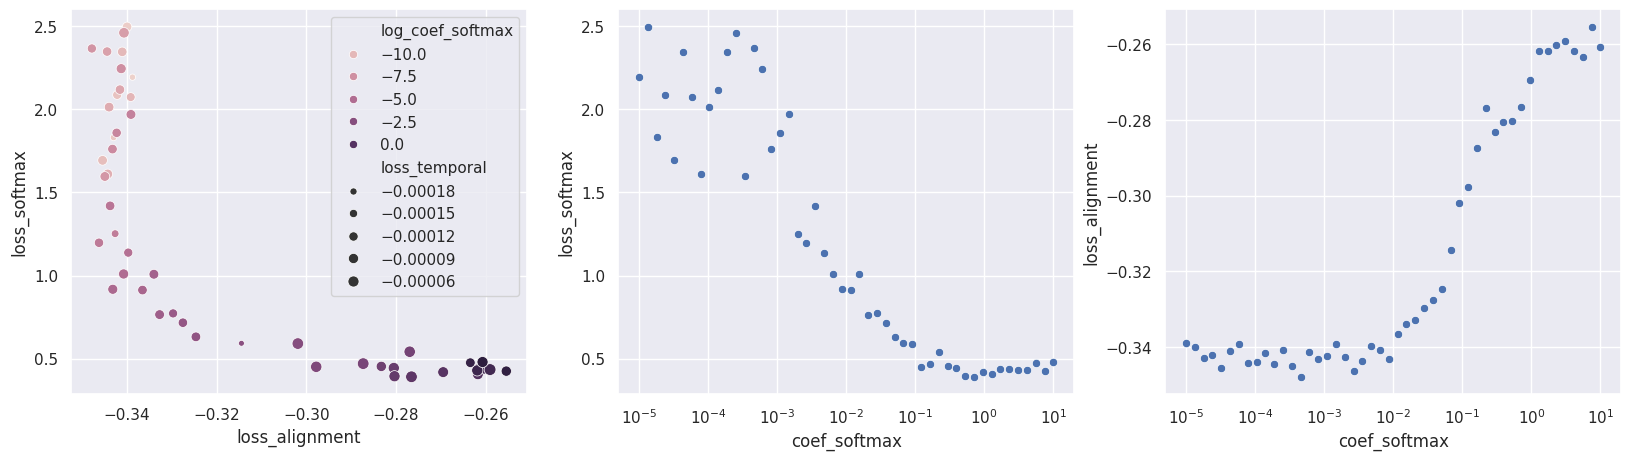

In [61]:
plt.figure(figsize=(20, 5))
plt.subplot(131)
sns.scatterplot(data=df, x='loss_alignment', y='loss_softmax', size='loss_temporal', hue='log_coef_softmax')
plt.subplot(132)
g = sns.scatterplot(data=df, x='coef_softmax', y='loss_softmax')
plt.xscale('log')
plt.subplot(133)
g = sns.scatterplot(data=df, x='coef_softmax', y='loss_alignment')
plt.xscale('log')

In [62]:
df[(df.loss_alignment<-0.325) & (df.loss_softmax<0.8)]

loss  loss_alignment  loss_softmax  loss_temporal  coef_alignment  \
26 -0.316780       -0.332736      0.765215      -0.000105             1.0   
27 -0.308118       -0.329728      0.772410      -0.000126             1.0   
28 -0.300646       -0.327536      0.716363      -0.000114             1.0   

    coef_softmax  log_coef_softmax  
26      0.020852         -3.870303  
27      0.027977         -3.576356  
28      0.037538         -3.282409